# Analysis of a public bike share network using Python and machine learning

##### J. Michael Shockley

5 March 2019

For a public bike share service to function smoothly, bikes and docks at which to anchor them need to be available at stations throughout the network. When popular stations run out of bikes or fill up with them, the functionality of the entire bike share network is decreased. Redistribution of bikes between stations alleviates this issue, yet the redistribution process is expensive and labor intensive. An important logistics problem arises out of predicting which stations that will gain or lose bicycles. A multitude of factors may influence the usage of a public bike share service, and these are no doubt interconnected: geographic location of a station, weather, time of day, day of the week, etc.

The goal of this project was to take several well-known data sets of a San Francisco Bay Area bike share company and examine the relationships between trip-by-trip usage data, daily weather conditions, and information about the stations themselves. A year's worth of data from a time period of 09/2014 to 08/2015 helped to build a model predicting hourly rate of change per station.

Although these are common data sets, all work below (methodology, code, analysis, conclusions) is my own work. This project was written in Python making use of Pandas and Numpy packages.

## 1 Extract raw data

Three files were obtained: trip_data.csv, weather_data.csv, and station_data.csv. The data is imported below as data frames and the .head() method shows the contents of each data set. The trip data file includes a unique trip ID, the start and end date/time of each trip, the corresponding start and end station of each trip, and the subscriber type. The weather data contains various metrics of the weather including total precipitation, cloud cover, wind direction, maximum/mean/mininum temperature, dew point, relative humidity, visibility, and wind speed, and stated weather events for each zip code in which the bike share system operates. The station data contains the station ID, name, geographic location, and number of docks for each bike station.

In [7]:
import pandas as pd
import numpy as np

#Trip data imported as dataframe TD
TD=pd.read_csv(
    "trip_data.csv", 
    header=0, 
    skip_blank_lines=False,
    parse_dates=['Start Date','End Date'],
    date_parser=lambda d: pd.to_datetime(
        d, format="%d/%m/%Y %H:%M", errors="coerce"
    )
)
TD.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type
0,913460,2015-08-31 23:26:00,50,2015-08-31 23:39:00,70,Subscriber
1,913459,2015-08-31 23:11:00,31,2015-08-31 23:28:00,27,Subscriber
2,913455,2015-08-31 23:13:00,47,2015-08-31 23:18:00,64,Subscriber
3,913454,2015-08-31 23:10:00,10,2015-08-31 23:17:00,8,Subscriber
4,913453,2015-08-31 23:09:00,51,2015-08-31 23:22:00,60,Customer


In [8]:
#Weather data imported as dataframe WD
WD=pd.read_csv(
    "weather_data.csv", 
    header=0, 
    skip_blank_lines=False,
    parse_dates=['Date'],
    date_parser=lambda d: pd.to_datetime(
        d, format="%d/%m/%Y", errors="coerce"
    )
)
WD.head()

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip
0,2014-09-01,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,10.0,8.0,16.0,7.0,20.0,0.0,0.0,NaN,290.0,94107
1,2014-09-02,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,...,10.0,7.0,21.0,8.0,NaN,0.0,5.0,NaN,290.0,94107
2,2014-09-03,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,...,10.0,10.0,21.0,8.0,24.0,0.0,4.0,NaN,276.0,94107
3,2014-09-04,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,...,10.0,8.0,22.0,8.0,25.0,0.0,5.0,NaN,301.0,94107
4,2014-09-05,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,...,9.0,7.0,18.0,8.0,32.0,0.0,4.0,NaN,309.0,94107


In [9]:
#Station data imported as dataframe SD
SD=pd.read_csv(
    "station_data.csv", 
    header=0, 
    skip_blank_lines=False
)
SD.head()

,Id,Name,Lat,Long,Dock Count,City
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose


## 2 Create a single data set of bikes entering and leaving each station, per hour

The first step to solving the logistics problem of interest requires transforming the raw trip data into an hourly change in bike count per station. This is calculated by counting the bikes entering and leaving each station for each hour during the time period. The next step is to merge the data sets using commmonalities between the data sets as join keys. This will serve as a template for later incorporating weather data (section 3).

First, the trip data (TD) is modified by correcting for stations that changed station ID over the time period. The numpy.select() function is used for this purpose.

In [10]:
#Modify rows in trip data (TD) for stations that changed station ID over the time period
conditions = [
    (TD['Start Station']==23),
    (TD['Start Station']==25),
    (TD['Start Station']==49),
    (TD['Start Station']==69),
    (TD['Start Station']==72),
    (TD['Start Station']==89),
    (TD['Start Station']!=23&25&49&69&72&89)] 
choices = [85,86, 87,88,90,90,TD['Start Station']]
TD['Start Station'] = np.select(conditions, choices)

conditions=[
    (TD['End Station']==23),
    (TD['End Station']==25),
    (TD['End Station']==49),
    (TD['End Station']==69),
    (TD['End Station']==72),
    (TD['End Station']==89),
    (TD['End Station']!=23&25&49&69&72&89)]
choices = [85,86, 87,88,90,90,TD['End Station']]
TD['End Station'] = np.select(conditions, choices)

Next, new columns are added to the trip data (TD) containing date/time data truncated to the hour, creating date/hour combinations.

In [11]:
#Use .dt.floor method to truncate trip data to the hour.
TD['Start Date Truncated']=TD['Start Date'].dt.floor('h')
TD['End Date Truncated']=TD['End Date'].dt.floor('h')
TD.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type,Start Date Truncated,End Date Truncated
0,913460,2015-08-31 23:26:00,50,2015-08-31 23:39:00,70,Subscriber,2015-08-31 23:00:00,2015-08-31 23:00:00
1,913459,2015-08-31 23:11:00,31,2015-08-31 23:28:00,27,Subscriber,2015-08-31 23:00:00,2015-08-31 23:00:00
2,913455,2015-08-31 23:13:00,47,2015-08-31 23:18:00,64,Subscriber,2015-08-31 23:00:00,2015-08-31 23:00:00
3,913454,2015-08-31 23:10:00,10,2015-08-31 23:17:00,8,Subscriber,2015-08-31 23:00:00,2015-08-31 23:00:00
4,913453,2015-08-31 23:09:00,51,2015-08-31 23:22:00,60,Customer,2015-08-31 23:00:00,2015-08-31 23:00:00


Now new data frames are created to collect the number of bikes entering and leaving each station by counting each date/hour combination for each station. The pandas .groupby() and .count() methods work similarly to the SQL statements GROUP BY and COUNT.

In [12]:
TD_bystation_bystartdate = (pd.DataFrame(TD.groupby(['Start Station','Start Date Truncated'])
                            ['Start Date Truncated']
                            .count()         
                            .fillna(0)))
TD_bystation_bystartdate.columns=['Start Count']
TD_bystation_bystartdate.reset_index(inplace=True)

TD_bystation_byenddate = (pd.DataFrame(TD.groupby(['End Station','End Date Truncated'])
                            ['End Date Truncated']
                            .count()         
                            .fillna(0)))
TD_bystation_byenddate.columns=['End Count']
TD_bystation_byenddate.reset_index(inplace=True)
TD_bystation_byenddate.head()

,End Station,End Date Truncated,End Count
0,2,2014-09-01 14:00:00,1
1,2,2014-09-02 06:00:00,3
2,2,2014-09-02 07:00:00,6
3,2,2014-09-02 08:00:00,1
4,2,2014-09-02 09:00:00,2


Finally, the hourly start/end trip counts for each station are consolidated into a single data set. First an empty data set is created containing every station ID and every date/hour combination in the one year period. In Pandas the MultiIndex.from_product() method is used, accomplishing a similar result to the CROSS JOIN statement in SQL. This creates an empty multi-index array DFMerge where the indices are station ID and the unique date/hour combinations.

In [13]:
#Create a data frame containing the station IDs
DFstation=SD['Id']
#Create a data frame containing every date/hour combination from 2014-09-01 to 2015-08-31
DFtime=pd.date_range(start=TD_bystation_byenddate['End Date Truncated'].min(), end=TD_bystation_byenddate['End Date Truncated'].max(), freq='h')
#Create a multi-index array where the indices are the station ID and unique date/hour combinations
DFMerge=pd.MultiIndex.from_product([DFstation,DFtime],names=['Station','Date/Hour'])
#Convert the multi-level indices to column values 
DFMerge=pd.DataFrame(index=DFMerge).reset_index()
DFMerge.head()

,Station,Date/Hour
0,2,2014-09-01 00:00:00
1,2,2014-09-01 01:00:00
2,2,2014-09-01 02:00:00
3,2,2014-09-01 03:00:00
4,2,2014-09-01 04:00:00


Then, the pd.merge function is used to incorporate the TD_bystation_bystartdate and TD_bystation_byenddate into DFMerge using station ID and date/hour combinations as join keys. This is functionally similar to the LEFT JOIN in SQL. The DFall data frame is created in the process.

In [28]:
DFall=pd.merge(left=DFMerge, right=TD_bystation_bystartdate, how='left', on=None, left_on=['Station','Date/Hour'], right_on=['Start Station','Start Date Truncated'])
DFall=pd.merge(left=DFall, right=TD_bystation_byenddate, how='left', on=None, left_on=['Station','Date/Hour'], right_on=['End Station','End Date Truncated'])
#Remove extraneous columns from the merge and fill in zero values as na
DFall=DFall.drop(columns=['Start Station','Start Date Truncated','End Station','End Date Truncated'])
DFall=DFall.fillna(0)

DFall.head()

,Station,Date/Hour,Start Count,End Count
0,2,2014-09-01 00:00:00,0.0,0.0
1,2,2014-09-01 01:00:00,0.0,0.0
2,2,2014-09-01 02:00:00,0.0,0.0
3,2,2014-09-01 03:00:00,0.0,0.0
4,2,2014-09-01 04:00:00,0.0,0.0


A new column, Net Bikes Per Hour, is calculated as the difference between incoming and outgoing bike counts.

In [29]:
DFall['Net Bikes Per Hour']=DFall['End Count']-DFall['Start Count']
DFall.head()

,Station,Date/Hour,Start Count,End Count,Net Bikes Per Hour
0,2,2014-09-01 00:00:00,0.0,0.0,0.0
1,2,2014-09-01 01:00:00,0.0,0.0,0.0
2,2,2014-09-01 02:00:00,0.0,0.0,0.0
3,2,2014-09-01 03:00:00,0.0,0.0,0.0
4,2,2014-09-01 04:00:00,0.0,0.0,0.0


## 3 Incorporate station information and weather data into the hourly trip data set

The DFall data frame contains a count of the bikes entering and leaving each station for each hour in the period between 2014-09-01 to 2015-08-31. Now, station data (SD) and weather data (WD) are merged into the data set.

First, the numpy.select() function is used to add the zip code to the station data (SD) data set.

In [30]:
#Add zip code column to station data (SD)
conditions = [
    (SD['City']=='San Jose'),
    (SD['City']=='Mountain View'),
    (SD['City']=='Palo Alto'),
    (SD['City']=='San Francisco'),
    (SD['City']=='Redwood City')]
     
choices = [95113, 94041, 94301,94107,94063]
SD['Zip'] = np.select(conditions, choices)

Then pd.merge is used to join the station information SD into the hourly trip data set, DFall.

In [31]:
DFall=pd.merge(left=DFall, right=SD, how='left', left_on=['Station'], right_on=['Id'])
#Remove extraneous columns
DFall=DFall.drop(columns=['Id','Dock Count'])
DFall.head()

,Station,Date/Hour,Start Count,End Count,Net Bikes Per Hour,Name,Lat,Long,City,Zip
0,2,2014-09-01 00:00:00,0.0,0.0,0.0,San Jose Diridon Caltrain Station,37.329732,-121.901782,San Jose,95113
1,2,2014-09-01 01:00:00,0.0,0.0,0.0,San Jose Diridon Caltrain Station,37.329732,-121.901782,San Jose,95113
2,2,2014-09-01 02:00:00,0.0,0.0,0.0,San Jose Diridon Caltrain Station,37.329732,-121.901782,San Jose,95113
3,2,2014-09-01 03:00:00,0.0,0.0,0.0,San Jose Diridon Caltrain Station,37.329732,-121.901782,San Jose,95113
4,2,2014-09-01 04:00:00,0.0,0.0,0.0,San Jose Diridon Caltrain Station,37.329732,-121.901782,San Jose,95113


To join the daily weather data (WD), a column is created to truncate the date/hour data to the date only. This permits the date to be used as a join key. The same is done to the weather data (WD) to avoid any risk of formatting errors. Then the two data sets are merged into a final data frame, DFfinal, using pd.merge(). The column Zip is used as an additional join key to match each station to the weather of its corresponding zip code.

In [32]:
DFall['Date']=DFall['Date/Hour'].dt.floor('D')
WD['DateTrunc']=WD['Date'].dt.floor('D')
DFfinal=pd.merge(left=DFall, right=WD, how='left', on=['Zip','Date'])
DFfinal.head()

,Station,Date/Hour,Start Count,End Count,Net Bikes Per Hour,Name,Lat,Long,City,Zip,...,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,DateTrunc
0,2,2014-09-01 00:00:00,0.0,0.0,0.0,San Jose Diridon Caltrain Station,37.329732,-121.901782,San Jose,95113,...,10.0,10.0,17.0,5.0,22.0,0.0,0.0,NaN,296.0,2014-09-01
1,2,2014-09-01 01:00:00,0.0,0.0,0.0,San Jose Diridon Caltrain Station,37.329732,-121.901782,San Jose,95113,...,10.0,10.0,17.0,5.0,22.0,0.0,0.0,NaN,296.0,2014-09-01
2,2,2014-09-01 02:00:00,0.0,0.0,0.0,San Jose Diridon Caltrain Station,37.329732,-121.901782,San Jose,95113,...,10.0,10.0,17.0,5.0,22.0,0.0,0.0,NaN,296.0,2014-09-01
3,2,2014-09-01 03:00:00,0.0,0.0,0.0,San Jose Diridon Caltrain Station,37.329732,-121.901782,San Jose,95113,...,10.0,10.0,17.0,5.0,22.0,0.0,0.0,NaN,296.0,2014-09-01
4,2,2014-09-01 04:00:00,0.0,0.0,0.0,San Jose Diridon Caltrain Station,37.329732,-121.901782,San Jose,95113,...,10.0,10.0,17.0,5.0,22.0,0.0,0.0,NaN,296.0,2014-09-01


Now that all of the trip, station, and weather data have been collected into a single dataframe, the relationships between them can be closely studied. A few extra columns are added for the ease of plotting: hour, weekday, and month are extracted from the Date/Hour column. 

In [47]:
#Extract and create new columns hour, weekday, and month from Date/Hour column
DFfinal['hour']=DFfinal['Date/Hour'].dt.hour
DFfinal['weekday']=DFfinal['Date/Hour'].dt.weekday+1
DFfinal['month']=DFfinal['Date/Hour'].dt.month
#Calculate absolute value of Net Bikes Per Hour column
DFfinal['Abs Net Bikes Per Hour']=DFfinal['Net Bikes Per Hour'].abs()
#Convert hour of day and weekday to numeric string
DFfinal['weekday_str']=DFfinal['weekday'].apply(str)
DFfinal['hour_str']=DFfinal['hour'].apply(str)
#Convert weekday to string
conditions = [
    (DFfinal['weekday_str']=='1'),
    (DFfinal['weekday_str']=='2'),
    (DFfinal['weekday_str']=='3'),
    (DFfinal['weekday_str']=='4'),
    (DFfinal['weekday_str']=='5'),
    (DFfinal['weekday_str']=='6'),
    (DFfinal['weekday_str']=='7')]
     
choices = ['Mon', 'Tues', 'Wed','Thur','Fri','Sat','Sun']
DFfinal['WeekdayName'] = np.select(conditions, choices)

In [48]:
DFfinal.head()

,Station,Date/Hour,Start Count,End Count,Net Bikes Per Hour,Name,Lat,Long,City,Zip,...,Events,WindDirDegrees,DateTrunc,hour,weekday,month,weekday_str,hour_str,Abs Net Bikes Per Hour,WeekdayName
0,2,2014-09-01 00:00:00,0.0,0.0,0.0,San Jose Diridon Caltrain Station,37.329732,-121.901782,San Jose,95113,...,NaN,296.0,2014-09-01,0,1,9,1,0,0.0,Mon
1,2,2014-09-01 01:00:00,0.0,0.0,0.0,San Jose Diridon Caltrain Station,37.329732,-121.901782,San Jose,95113,...,NaN,296.0,2014-09-01,1,1,9,1,1,0.0,Mon
2,2,2014-09-01 02:00:00,0.0,0.0,0.0,San Jose Diridon Caltrain Station,37.329732,-121.901782,San Jose,95113,...,NaN,296.0,2014-09-01,2,1,9,1,2,0.0,Mon
3,2,2014-09-01 03:00:00,0.0,0.0,0.0,San Jose Diridon Caltrain Station,37.329732,-121.901782,San Jose,95113,...,NaN,296.0,2014-09-01,3,1,9,1,3,0.0,Mon
4,2,2014-09-01 04:00:00,0.0,0.0,0.0,San Jose Diridon Caltrain Station,37.329732,-121.901782,San Jose,95113,...,NaN,296.0,2014-09-01,4,1,9,1,4,0.0,Mon


## 4 Relationships

### Bike share usage by day of the week: two stations

For two selected stations (Station IDs 65 and 70), the hourly change in bikes per station is plotted below as a scatter plot as a function of time of day (24-hour scale) between 5am and 9pm. The line of best fit is plotted as well in yellow.

In [50]:
import plotnine as p9
import skmisc

#Subset DFfinal to stations 65 and 70
DFfinal_65_70 = DFfinal[DFfinal["Station"].isin([65, 70])]
#Subset DFfinal to stations 65 and 70 between 5am and 9pm
DFfinal_65_70_day = DFfinal[DFfinal["Station"].isin([65, 70]) & DFfinal['hour'].isin(list(range(5,21)))]

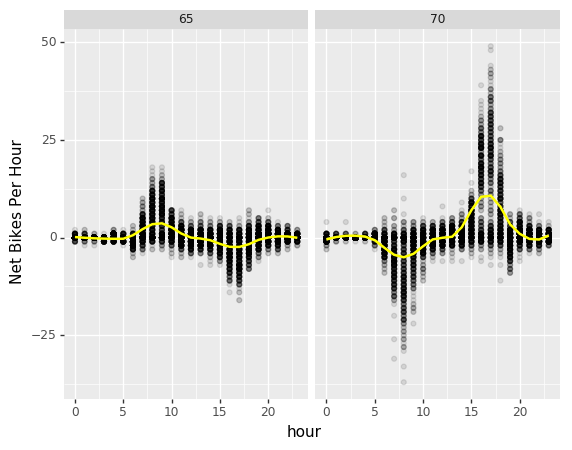

<ggplot: (-9223372036546818486)>

In [43]:
#Scatter plot with line of best fit shown in yellow
(p9.ggplot(data=DFfinal_65_70,
          mapping=p9.aes(x="hour", y="Net Bikes Per Hour"))
    + p9.geom_point(alpha=0.1)
    + p9.facet_wrap("Station")
    + p9.geom_smooth(method="loess",size=1, color="yellow",alpha=1,se=True,span=0.4,level=0.9)
)

For stations 65 and 70, the highest rate of change of bikes per station occurs during the morning and evening rush hours. The least amount of usage is at night. Interestingly, the stations have differing trends in morning/evening usage due to their location: stations 65 is located near the financial district, implying riders are commuting to these stations in the morning and vice/versa. Station 70 is located next to a commuter rail station, implying riders are commuting from this station in the morning. _Importantly, this shows that a single model will not apply to the entire data set; a unique model must be produced for each station._

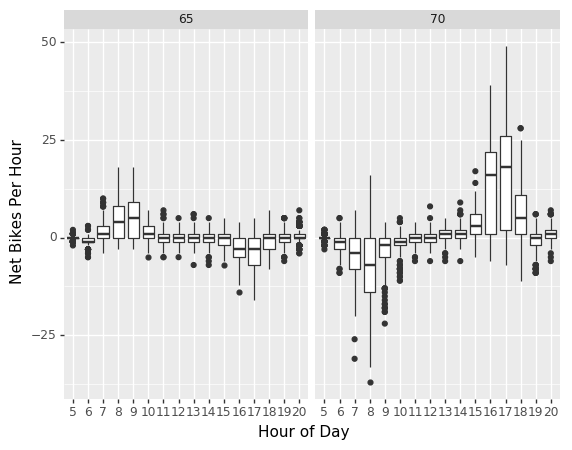

<ggplot: (-9223372036559793250)>

In [55]:
(p9.ggplot(data=DFfinal_65_70_day,
          mapping=p9.aes(x="hour_str", y="Net Bikes Per Hour"))
    #+ p9.geom_point(alpha=0.1)
    + p9.geom_boxplot()
    + p9.facet_wrap("Station")
    +p9.xlab("Hour of Day")
    +p9.scale_x_discrete(limits=[str(i) for i in list(range(5,21))])
)

Box plots reveal richer statistical detail than the scatter plot above, showing the behavior over the course of the day. Station 70 is clearly more heavily used than station 65.

### Bike share usage by day of the week: two stations

The day of the week reveals that 

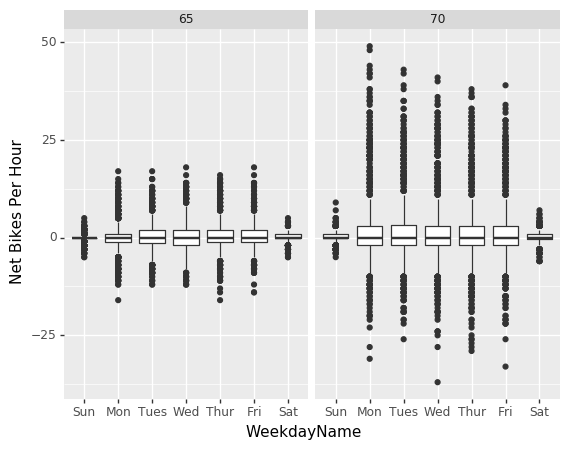

<ggplot: (319876840)>

In [53]:
(p9.ggplot(data=DFfinal_65_70_day,
          mapping=p9.aes(x="WeekdayName", y="Net Bikes Per Hour"))
    #+ p9.geom_point(alpha=0.1)
    + p9.geom_boxplot()
    + p9.facet_wrap("Station")
    +p9.scale_x_discrete(limits=['Sun','Mon','Tues','Wed','Thur','Fri','Sat'])
)